In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [99]:
boston = pd.read_csv("./data/obligatoria_hard.csv", sep = "|")

### Funcion: get_features_num_regression

Esta función recibe como argumentos un dataframe, el nombre de una de las columnas del mismo (argumento 'target_col'), que debería ser el target de un hipotético modelo de regresión, es decir debe ser una variable numérica continua o discreta pero con alta cardinalidad, además de un argumento 'umbral_corr', de tipo float que debe estar entre 0 y 1 y una variable float "pvalue" cuyo valor debe ser por defecto "None".

La función debe devolver una lista con las columnas numéricas del dataframe cuya correlación con la columna designada por "target_col" sea superior en valor absoluto al valor dado por "umbral_corr". Además si la variable "pvalue" es distinta de None, sólo devolvera las columnas numéricas cuya correlación supere el valor indicado y además supere el test de hipótesis con significación mayor o igual a 1-pvalue.

La función debe hacer todas las comprobaciones necesarias para no dar error como consecuecia de los valores de entrada. Es decir hará un check de los valores asignados a los argumentos de entrada y si estos no son adecuados debe retornar None y printar por pantalla la razón de este comportamiento. Ojo entre las comprobaciones debe estar que "target_col" hace referencia a una variable numérica continua del dataframe.

In [101]:
def tipifica_variables(df, umbral_categoria, umbral_continua):

    """
    Función que clasifica las variables del DataFrame en tipos sugeridos

    Argumentos:
    df (DataFrame): DataFrame cuyas variables queremos clasificar
    umbral_categoria (int): Umbral para considerar una variable como categórica
    umbral_continua (float): Umbral para considerar una variable como numérica continua

    Retorna:
    DataFrame: Devuelve un DataFrame con dos columnas: "nombre_variable" y "tipo_sugerido"
    """

    # Crear una lista con la tipificación sugerida para cada variable
    lista_tipifica = []

    # Iterar sobre cada columna del DataFrame
    for columna in df.columns:

        # Obtener la cardinalidad
        cardinalidad = len(df[columna].unique())

        # Determinar el tipo
        if cardinalidad == 2:
            lista_tipifica.append("Binaria")
        elif cardinalidad < umbral_categoria:
            lista_tipifica.append("Categórica")
        else:
            porcentaje_cardinalidad = (cardinalidad / len(df))*100
            if porcentaje_cardinalidad >= umbral_continua:
                lista_tipifica.append("Numérica Continua")
            else:
                lista_tipifica.append("Numérica Discreta")

    # Agregar el resultado a un nuevo DataFrame con los resultados
    resultado_tipifica = pd.DataFrame({"nombre_variable" : df.columns.tolist(), "tipo_sugerido" : lista_tipifica})

    return resultado_tipifica

In [102]:
def get_features_num_regression(df, target_col, umbral_corr, pvalue = None):

    """
    Está función debe devolver una lista con las columnas numéricas del dataframe cuya correlación con la columna designada por "target_col" 
    sea superior en valor absoluto al valor dado por "umbral_corr". Además si la variable "pvalue" es distinta de None, sólo devolverá las 
    columnas numéricas cuya correlación supere el valor indicado y además supere el test de hipótesis con significación mayor o igual a 1-pvalue.

    Argumentos:
    - df (DataFrame): un dataframe de Pandas.
    - target_col (string): el nombre de la columna del Dataframe objetivo.
    - umbral_corr (float): un valor de correlación arbitrario sobre el que se elegirá como de correlacionadas queremos que estén las columnas elegidas (por defecto 0).
    - pvalue (float): con valor "None" por defecto.

    Retorna:
    - Lista de las columnas correlacionadas que cumplen el test en caso de que se haya pasado p-value.
    """

    # Comprobaciones

    if not isinstance(df, pd.DataFrame):
        print("Error: No has introducido un DataFrame válido de pandas.")
        return None
    
    # Comprobar si target_col está en el DataFrame
    if target_col not in df.columns:
        print(f"Error: La columna {target_col} no está en el DataFrame.")
        return None
    
    # Comprobar si target_col es numérico
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna {target_col} no es numérica.")
        return None
    
    # Comprobar si umbral_corr está entre 0 y 1
    if not 0 <= umbral_corr <= 1:
        print("Error: El umbral_corr debe estar entre 0 y 1.")
        return None

    # Comprobar si pvalue, si está definido, es un número entre 0 y 1
    if pvalue is not None:
        if not 0 <= pvalue <= 1:
            print("Error: El pvalue debe estar entre 0 y 1.")
            return None
        
    # Código
    var_tip = tipifica_variables(df, 10, 20)
    col_num = var_tip[(var_tip["tipo_sugerido"] == "Numérica Continua") | (var_tip["tipo_sugerido"] == "Numérica Discreta")]["nombre_variable"].tolist()

    # Se realizan las correlaciones y se eligen las que superen el umbral
    correlaciones = df[col_num].corr()[target_col]
    columnas_filtradas = correlaciones[abs(correlaciones) > umbral_corr].index.tolist()
    if target_col in columnas_filtradas:
        columnas_filtradas.remove(target_col)
    
    # Comprobación de que si se introduce un p-value pase los tests de hipótesis
    if pvalue is not None:
        columnas_finales = []
        for col in columnas_filtradas:
            p_value_especifico = pearsonr(df[col], df[target_col])[1]
            if pvalue < (1 - p_value_especifico):
                columnas_finales.append(col)
        columnas_filtradas = columnas_finales.copy()

    return columnas_filtradas

In [103]:
get_features_num_regression(boston, "MEDV", 0.5)

['RM', 'PTRATIO', 'LSTAT']

In [104]:
get_features_num_regression(boston, "MEDV", 0.7)

['LSTAT']

In [105]:
get_features_num_regression(boston, "MEDV", 0.7, 0.05)

['LSTAT']

### Funcion: plot_features_num_regression

Esta función recibe un dataframe, una argumento "target_col" con valor por defecto "", una lista de strings ("columns") cuyo valor por defecto es la lista vacía, un valor de correlación ("umbral_corr", con valor 0 por defecto) y un argumento ("pvalue") con valor "None" por defecto.

Si la lista no está vacía, la función pintará una pairplot del dataframe considerando la columna designada por "target_col" y aquellas incluidas en "column" que cumplan que su correlación con "target_col" es superior en valor absoluto a "umbral_corr", y que, en el caso de ser pvalue diferente de "None", además cumplan el test de correlación para el nivel 1-pvalue de significación estadística. La función devolverá los valores de "columns" que cumplan con las condiciones anteriores. 

EXTRA: Se valorará adicionalmente el hecho de que si la lista de columnas a pintar es grande se pinten varios pairplot con un máximo de cinco columnas en cada pairplot (siendo siempre una de ellas la indicada por "target_col")

Si la lista está vacía, entonces la función igualará "columns" a las variables numéricas del dataframe y se comportará como se describe en el párrafo anterior.

De igual manera que en la función descrita anteriormente deberá hacer un check de los valores de entrada y comportarse como se describe en el último párrafo de la función `get_features_num_regresion`

In [106]:
def plot_features_num_regression(df, target_col = "", columns = [], umbral_corr = 0, pvalue = None):
    
    """
    Está función pintará una pairplot del dataframe considerando la columna designada por "target_col" y aquellas 
    incluidas en "column" que cumplan que su correlación con "target_col" es superior en valor absoluto a "umbral_corr", 
    y que, en el caso de ser pvalue diferente de "None", además cumplan el test de correlación para el nivel 1-pvalue de significación estadística. 
    La función devolverá los valores de "columns" que cumplan con las condiciones anteriores.

    Argumentos:
    - df (DataFrame): un dataframe de Pandas.
    - target_col (string): el nombre de la columna del Dataframe objetivo.
    - columns (list): una lista de strings cuyo valor por defecto es la lista vacía.
    - umbral_corr (float): un valor de correlación arbitrario sobre el que se elegirá como de correlacionadas queremos que estén las columnas elegidas (por defecto 0).
    - pvalue (float): con valor "None" por defecto.

    Retorna:
    - Pairplots: columnas correlacionadas y la columna objetivo bajo nuestro criterio.
    - Lista de las columnas correlacionadas.
    """

    # Comprobaciones
    
    # Si la lista de columnas está vacía, asignar todas las variables numéricas del dataframe
    if not columns:
        columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Si se proporciona una lista de columnas, comprobar si están en el DataFrame
    else:
        for col in columns:
            if col not in df.columns:
                print(f"Error: La columna {col} no está en el DataFrame.")
                return None
    
    columnas_filtradas = get_features_num_regression(df, target_col, umbral_corr, pvalue)
    
    # Divide la lista de columnas filtradas en grupos de máximo cinco columnas
    columnas_agrupadas = [columnas_filtradas[i:i+4] for i in range(0, len(columnas_filtradas), 4)]
    
    # Generar pairplots para cada grupo de columnas
    for group in columnas_agrupadas:
        sns.pairplot(df[[target_col] + group])
        plt.show()
    
    # Devolver la lista de columnas filtradas
    return columnas_filtradas

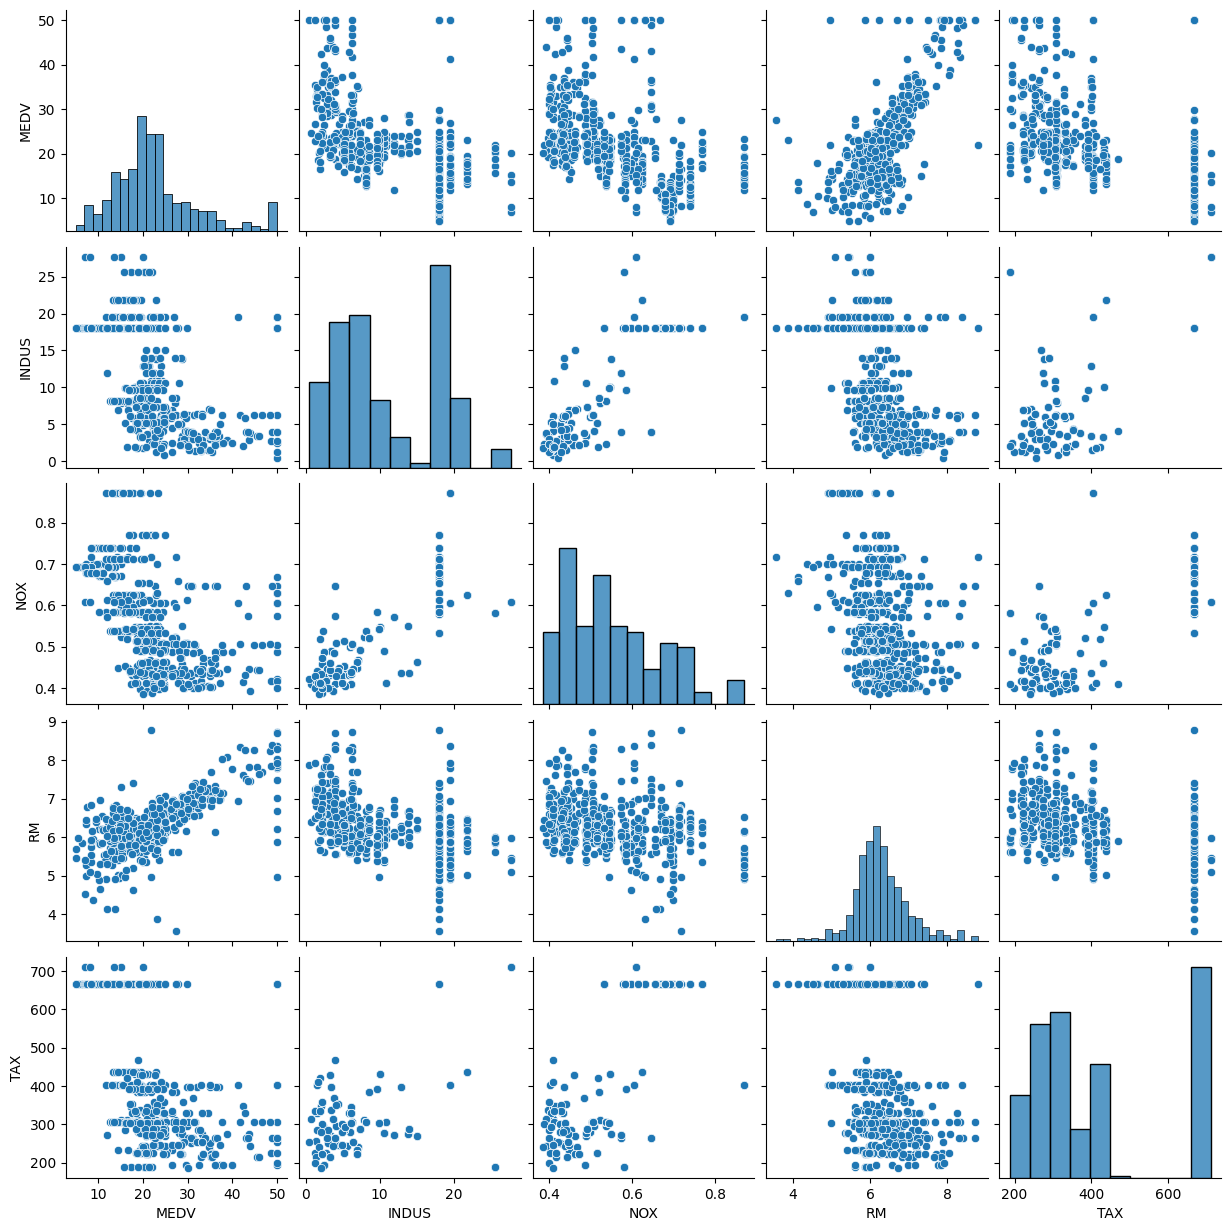

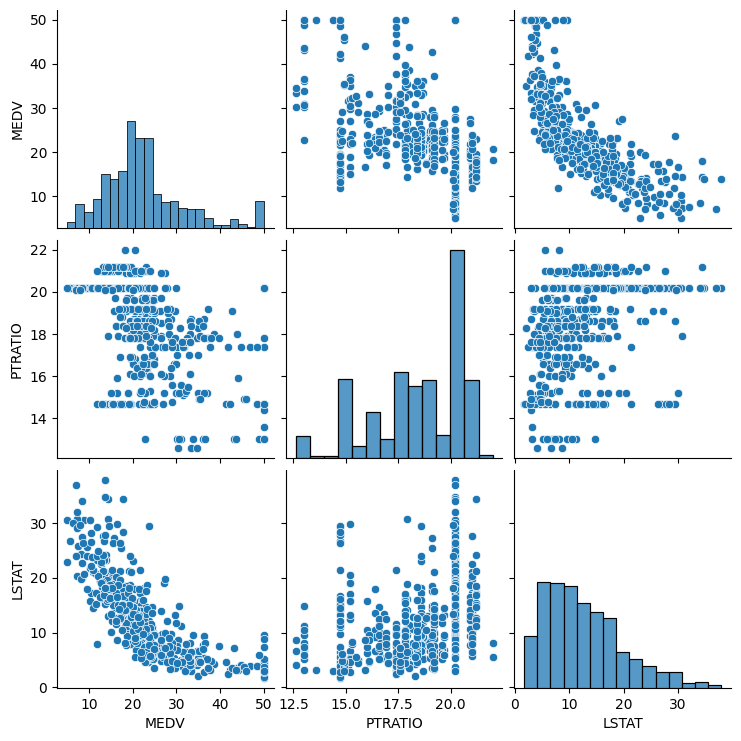

['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']

In [107]:
plot_features_num_regression(boston, "MEDV", umbral_corr = 0.4)

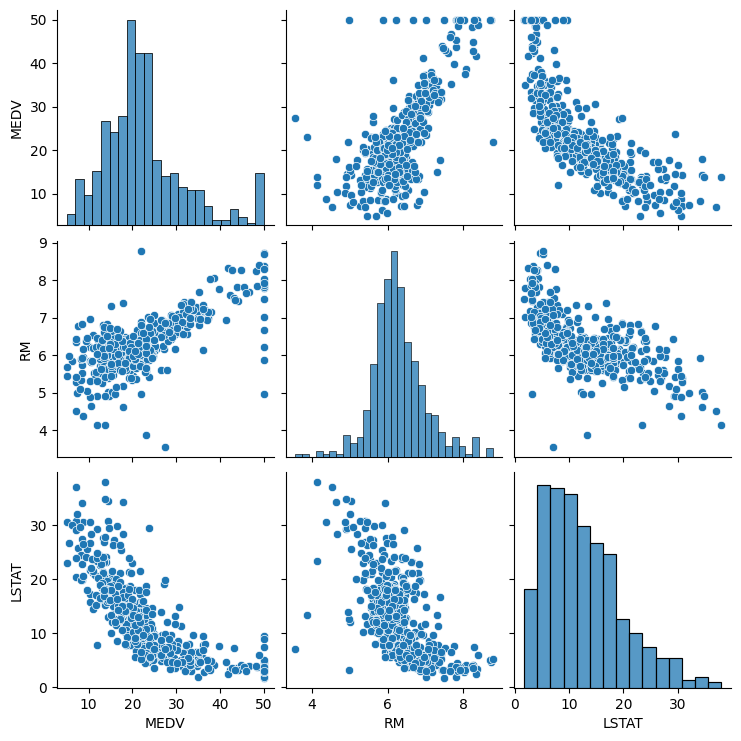

['RM', 'LSTAT']

In [108]:
plot_features_num_regression(boston, "MEDV", umbral_corr = 0.6)

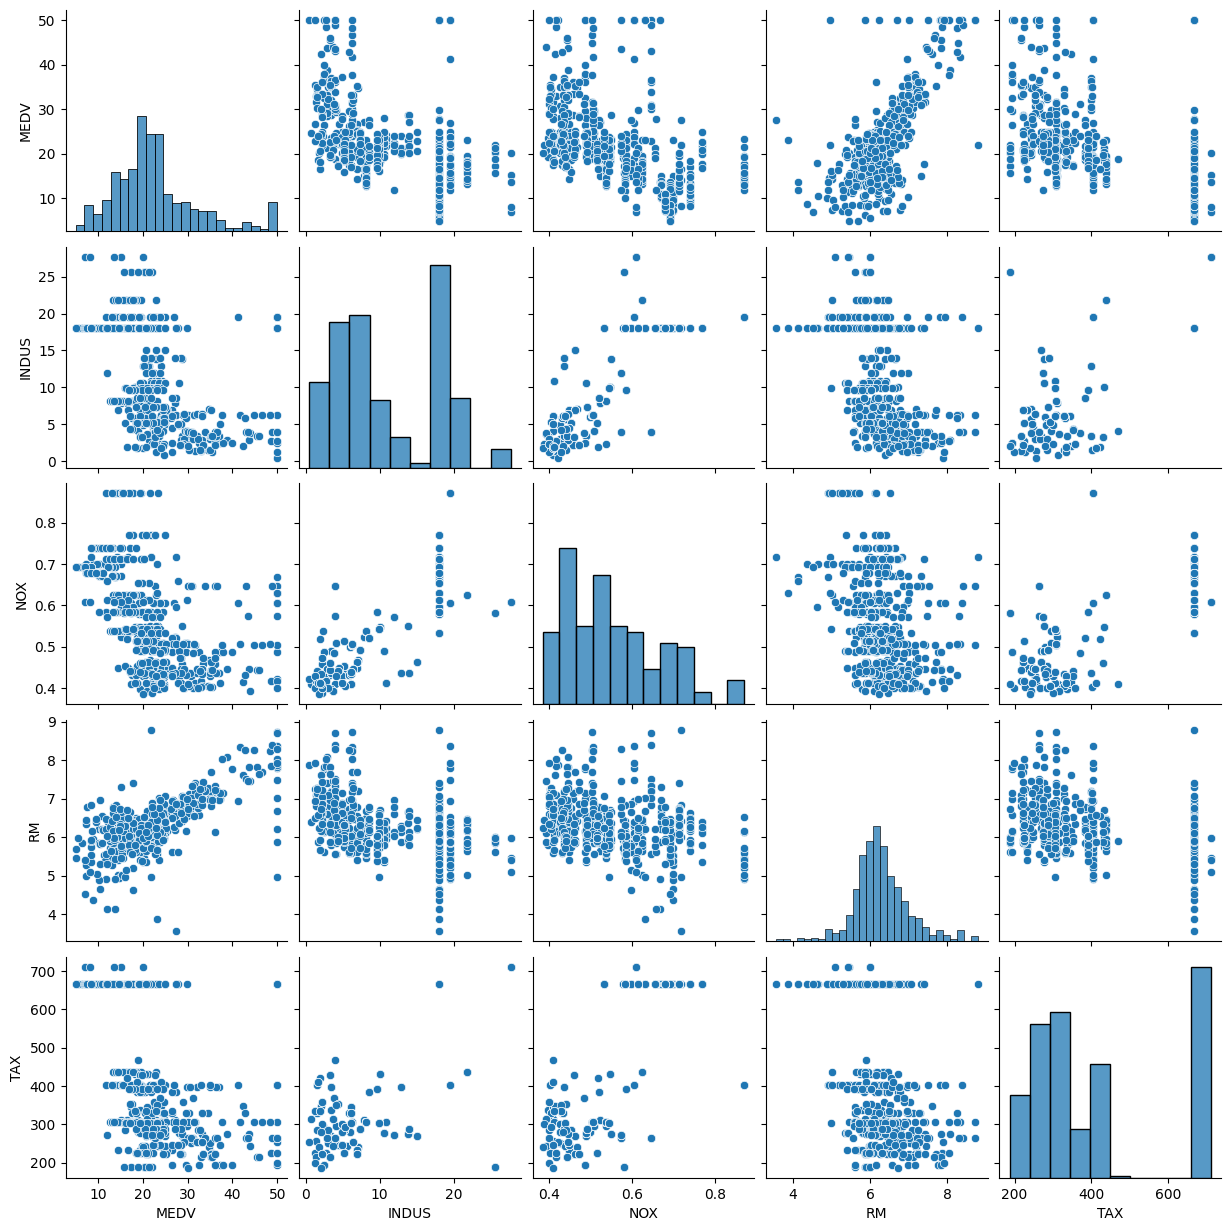

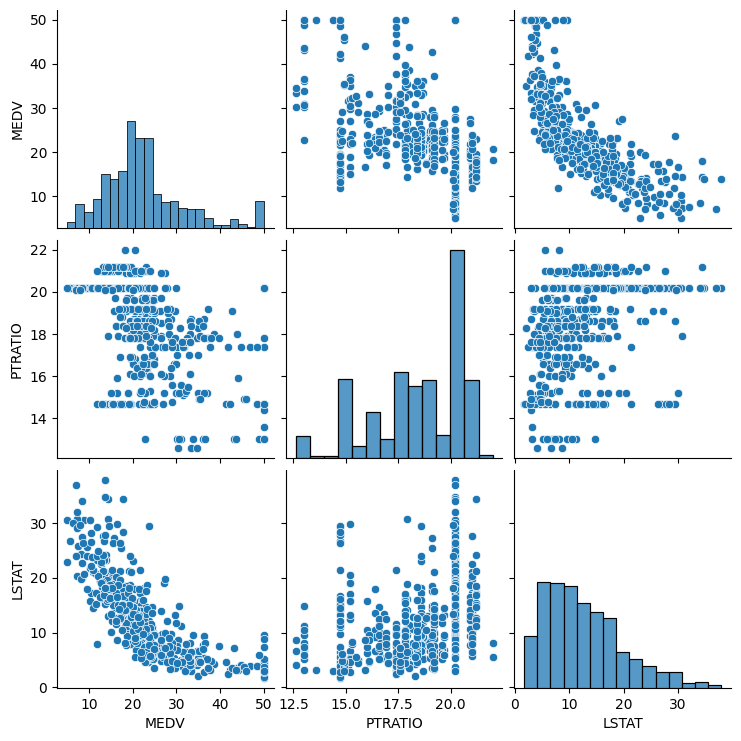

['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']

In [109]:
plot_features_num_regression(boston, "MEDV", umbral_corr = 0.4, pvalue = 0.5)

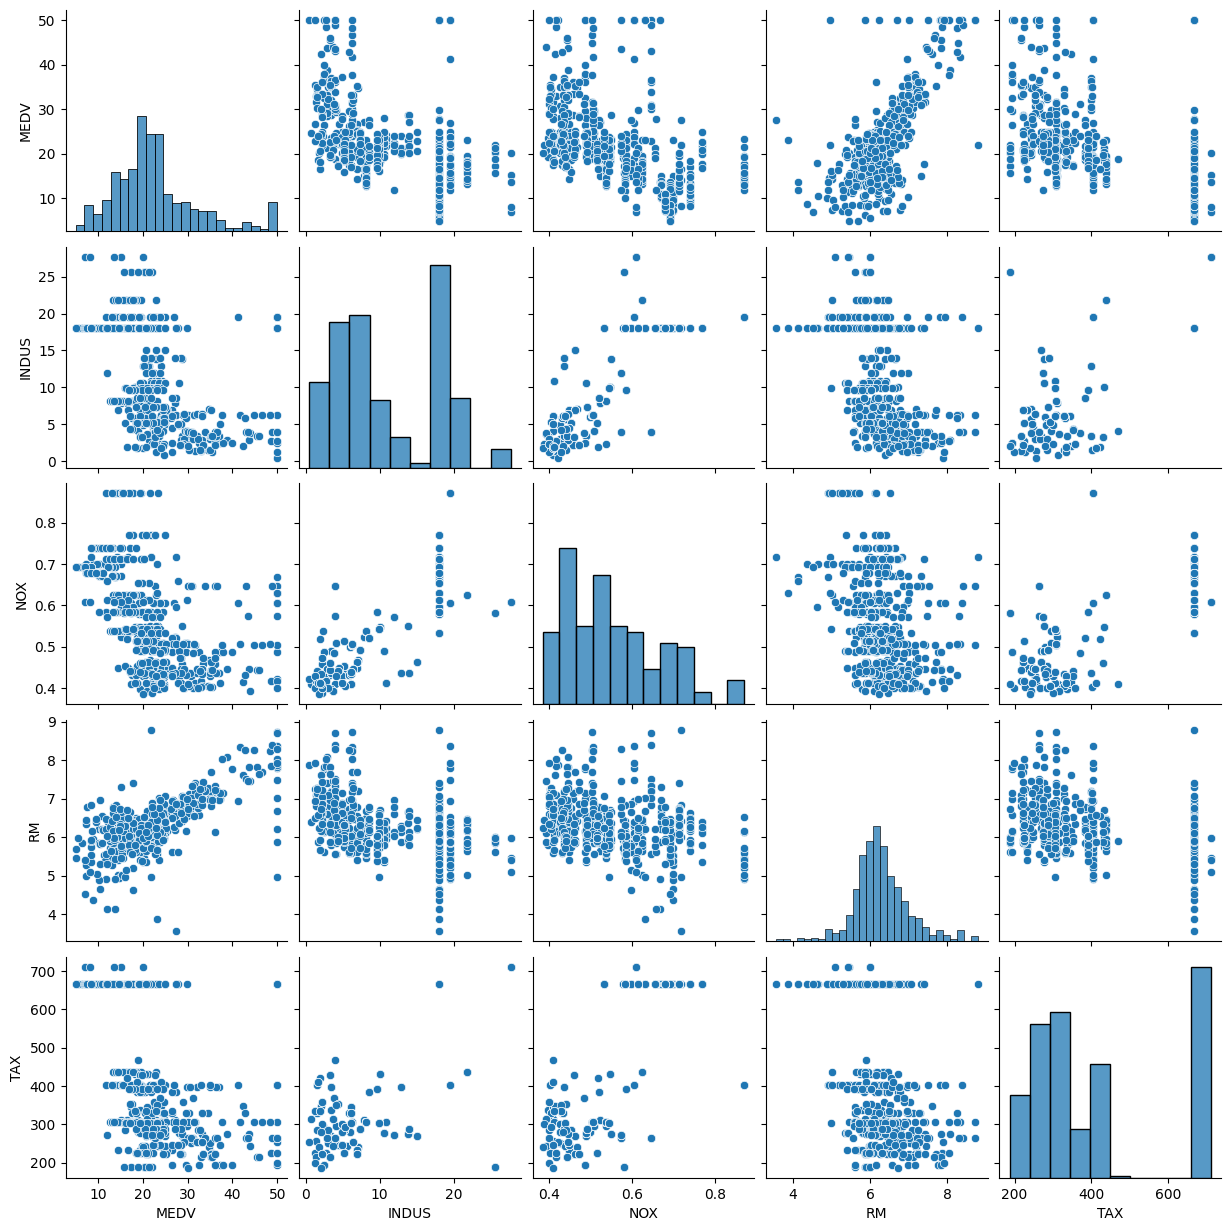

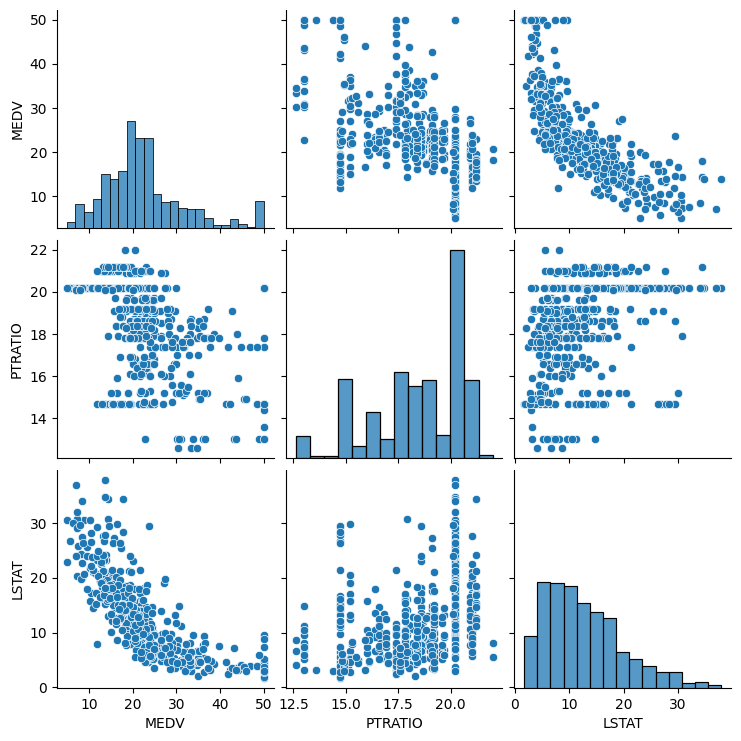

['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']

In [110]:
plot_features_num_regression(boston, "MEDV", ["NOX", "INDUS", "RM", "LSTAT", "PTRATIO", "TAX"], 0.4)

--------

### Borradores

In [ ]:
def plot_features_num_regression(df, target_col = "", columns = [], umbral_corr = 0, pvalue = None):
    
    """
    Está función pintará una pairplot del dataframe considerando la columna designada por "target_col" y aquellas 
    incluidas en "column" que cumplan que su correlación con "target_col" es superior en valor absoluto a "umbral_corr", 
    y que, en el caso de ser pvalue diferente de "None", además cumplan el test de correlación para el nivel 1-pvalue de significación estadística. 
    La función devolverá los valores de "columns" que cumplan con las condiciones anteriores.

    Argumentos:
    - df (DataFrame): un dataframe de Pandas.
    - target_col (string): el nombre de la columna del Dataframe objetivo.
    - columns (list): una lista de strings cuyo valor por defecto es la lista vacía.
    - umbral_corr (float): un valor de correlación arbitrario sobre el que se elegirá como de correlacionadas queremos que estén las columnas elegidas (por defecto 0).
    - pvalue (float): con valor "None" por defecto.

    Retorna:
    - Pairplots: columnas correlacionadas y la columna objetivo bajo nuestro criterio.
    - Lista de las columnas correlacionadas.
    """

    # Comprobaciones

    # Comprobar si el dataframe es un DataFrame de pandas
    if not isinstance(df, pd.DataFrame):
        print("Error: No has introducido un DataFrame válido de pandas.")
        return None
    
    # Comprobar si target_col está en el DataFrame
    if target_col != "" and target_col not in df.columns:
        print(f"Error: La columna {target_col} no está en el DataFrame.")
        return None
    
    # Comprobar si target_col es numérico si se proporciona
    if target_col != "" and not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna {target_col} no es numérica.")
        return None
    
    # Comprobar si umbral_corr está entre 0 y 1
    if not 0 <= umbral_corr <= 1:
        print("Error: El umbral_corr debe estar entre 0 y 1.")
        return None
    
    # Comprobar si pvalue, si está definido, es un número entre 0 y 1
    if pvalue is not None:
        if not 0 <= pvalue <= 1:
            print("Error: El pvalue debe estar entre 0 y 1.")
            return None
    
    # Si la lista de columnas está vacía, asignar todas las variables numéricas del dataframe
    
    if not columns:
        columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Si se proporciona una lista de columnas, comprobar si están en el DataFrame
    else:
        for col in columns:
            if col not in df.columns:
                print(f"Error: La columna {col} no está en el DataFrame.")
                return None
            
    # Código
    
    var_tip = tipifica_variables(df[columns], 10, 20)
    col_num = var_tip[(var_tip["tipo_sugerido"] == "Numérica Continua") | (var_tip["tipo_sugerido"] == "Numérica Discreta")]["nombre_variable"].tolist()

    
    # Calcula las correlaciones y filtra las columnas según el umbral y p-value
    columnas_filtradas = []
    for col in col_num:
        if col != target_col:
            correlation = pearsonr(df[col], df[target_col])[0]
            if abs(correlation) > umbral_corr:
                p_value_especifico = pearsonr(df[col], df[target_col])[1]
                print(p_value_especifico)
                if pvalue is None or pvalue < (1 - p_value_especifico):
                    columnas_filtradas.append(col)

    
    # Divide la lista de columnas filtradas en grupos de máximo cinco columnas
    columnas_agrupadas = [columnas_filtradas[i:i+4] for i in range(0, len(columnas_filtradas), 4)]
    
    # Generar pairplots para cada grupo de columnas
    for group in columnas_agrupadas:
        sns.pairplot(df[[target_col] + group])
        plt.show()
    
    # Devolver la lista de columnas filtradas
    return columnas_filtradas

In [ ]:
def plot_features_num_regression(df, target_col = "", columns = [], umbral_corr = 0, pvalue = None):
    
    """
    Está función pintará una pairplot del dataframe considerando la columna designada por "target_col" y aquellas 
    incluidas en "column" que cumplan que su correlación con "target_col" es superior en valor absoluto a "umbral_corr", 
    y que, en el caso de ser pvalue diferente de "None", además cumplan el test de correlación para el nivel 1-pvalue de significación estadística. 
    La función devolverá los valores de "columns" que cumplan con las condiciones anteriores.

    Argumentos:
    - df (DataFrame): un dataframe de Pandas.
    - target_col (string): el nombre de la columna del Dataframe objetivo.
    - columns (list): una lista de strings cuyo valor por defecto es la lista vacía.
    - umbral_corr (float): un valor de correlación arbitrario sobre el que se elegirá como de correlacionadas queremos que estén las columnas elegidas (por defecto 0).
    - pvalue (float): con valor "None" por defecto.

    Retorna:
    - Pairplots: columnas correlacionadas y la columna objetivo bajo nuestro criterio.
    - Lista de las columnas correlacionadas.
    """

    # Comprobaciones

    # Comprobar si el dataframe es un DataFrame de pandas
    if not isinstance(df, pd.DataFrame):
        print("Error: No has introducido un DataFrame válido de pandas.")
        return None
    
    # Comprobar si target_col está en el DataFrame
    if target_col != "" and target_col not in df.columns:
        print(f"Error: La columna {target_col} no está en el DataFrame.")
        return None
    
    # Comprobar si target_col es numérico si se proporciona
    if target_col != "" and not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna {target_col} no es numérica.")
        return None
    
    # Comprobar si umbral_corr está entre 0 y 1
    if not 0 <= umbral_corr <= 1:
        print("Error: El umbral_corr debe estar entre 0 y 1.")
        return None
    
    # Comprobar si pvalue, si está definido, es un número entre 0 y 1
    if pvalue is not None:
        if not 0 <= pvalue <= 1:
            print("Error: El pvalue debe estar entre 0 y 1.")
            return None
    
    # Si la lista de columnas está vacía, asignar todas las variables numéricas del dataframe
    
    if not columns:
        columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Si se proporciona una lista de columnas, comprobar si están en el DataFrame
    else:
        for col in columns:
            if col not in df.columns:
                print(f"Error: La columna {col} no está en el DataFrame.")
                return None
            
    # Código
    
    var_tip = tipifica_variables(df[columns], 10, 20)
    col_num = var_tip[(var_tip["tipo_sugerido"] == "Numérica Continua") | (var_tip["tipo_sugerido"] == "Numérica Discreta")]["nombre_variable"].tolist()

     # Se realizan las correlaciones y se eligen las que superen el umbral
    correlaciones = df[col_num].corr()[target_col]
    columnas_filtradas = correlaciones[abs(correlaciones) > umbral_corr].index.tolist()
    
    # Comprobación de que si se introduce un p-value pase los tests de hipótesis
    if pvalue is not None:
        columnas_finales = []
        for col in columnas_filtradas:
            p_value_especifico = pearsonr(df[col], df[target_col])[1]
            if pvalue < (1 - p_value_especifico):
                columnas_finales.append(col)
    
    
    
    # Divide la lista de columnas filtradas en grupos de máximo cinco columnas
    columnas_agrupadas = [columnas_filtradas[i:i+4] for i in range(0, len(columnas_filtradas), 4)]
    
    # Generar pairplots para cada grupo de columnas
    for group in columnas_agrupadas:
        sns.pairplot(df[[target_col] + group])
        plt.show()
    
    # Devolver la lista de columnas filtradas
    return columnas_filtradas